<h2 align="center">Ocean Data Science 2022</h2> 

___

<a href='https://github.com/obidam/ds2-2022'>
<img src="logos.png" alt="drawing" /></a>

___

<h1 align="center">Ocean Warming Contribution to Sea Level Rise</h1> 

<h2 align="center">Joséphine Schmutz, Mario Herrero González</h2> 

<h4 align="center">josephine.schmutz@gmail.com, marioherreroglez34@gmail.com</h4> 

## Index

1. [Introduction](#intro)
2. [Exploratory Data Analysis (EDA)](#EDA)
3. [Methods](#met)
5. [Results](#res)
6. [Conclusions](#concl)
7. [Discussion](#disc)

<a name='intro'></a>
## Introduction

- Scientific motivation and Big Data approach
- Explain objectives
- What is and why to use the Pangeo project platform
- What is the gsw library



<a name='EDA'></a>
## Exploratory Data Analysis

- Open dataset
- Clean/Treat data, possible outliers/ice?
- Plot some examples
- Plot whisker diagram?
- Plot 1D / 2D distributions/ heatmaps?


In [14]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
#Also import basemap cartopy or plotly
from intake import open_catalog
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,8)

In [16]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2022/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
ds = cat["en4"].to_dask()

In [19]:
ds_ssh = cat["sea_surface_height"].to_dask()

In [20]:
ds

<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173, lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

In [21]:
ds_ssh

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2018-12-01
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Note:                            Generated by G. Maze with 31 daily files
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-31T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1993-01-30T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

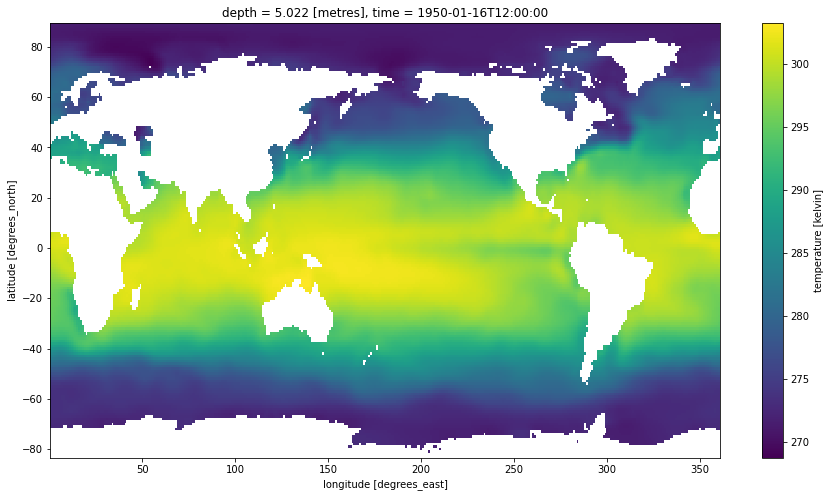

In [13]:
ds.isel(depth=0, time=0).temperature.plot() # First example, will be ploted better changing labels

<a name='met'></a>
## Methods

- Aim of this section: Explain important physical aspects/definitions (e.g. dynamic effect and steric effect, regional trends).
- Calculate Ocean Heat content?
- Thermosteric effect
- Plot some examples
- Plot whisker diagram?
- Plot 1D / 2D distributions/ statistical heatmaps?

<a name='res'></a>
## Results

- Calculate what was previously explained
- Comment correctly the code
- Show plots with correct units (Kelvins for Temperature, meters for SSH)

<a name='concl'></a>
## Conclusions

- Has it been possible to demonstrate that the thermosteric effect is the primary driver of regional trends?
- Other interesting facts

<a name='disc'></a>
## Discussion

- Improvements
- Use of any other library, xgcm?
- How to account for dynamic effect?
- Any possible future study?